Experiment with a 9000K continumn model from https://arxiv.org/pdf/2201.08805.pdf - can we normalize it to the NUV spectrum?

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from scipy.interpolate import interpolate
from craftroom import resample
from astropy.convolution import convolve, Box1DKernel
from astropy.modeling import models, fitting
from scipy.optimize import leastsq
from astropy.modeling import functional_models
from matplotlib.gridspec import GridSpec

#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20


In [2]:
path = '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/' 

In [3]:
stars = os.listdir(path)
stars

['GJ1132',
 'GJ15A',
 'GJ163',
 'GJ649',
 'GJ674',
 'GJ676A',
 'GJ699',
 'GJ729',
 'GJ849',
 'L-980-5',
 'LHS-2686',
 'TRAPPIST-1']

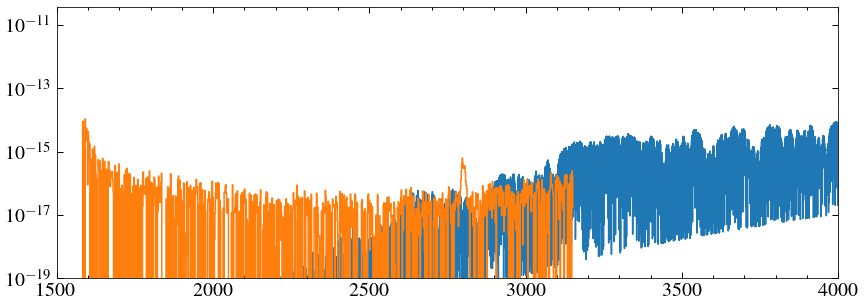

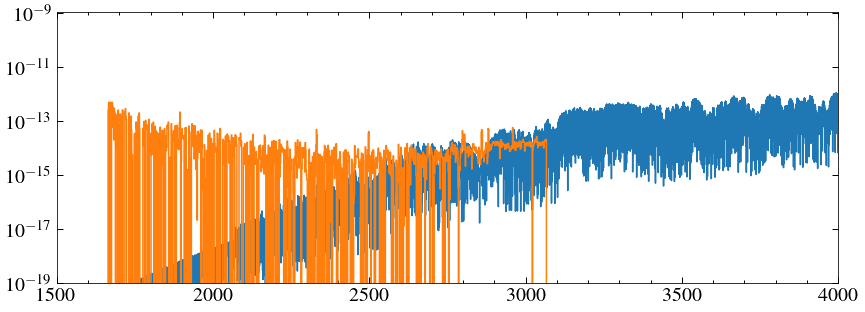

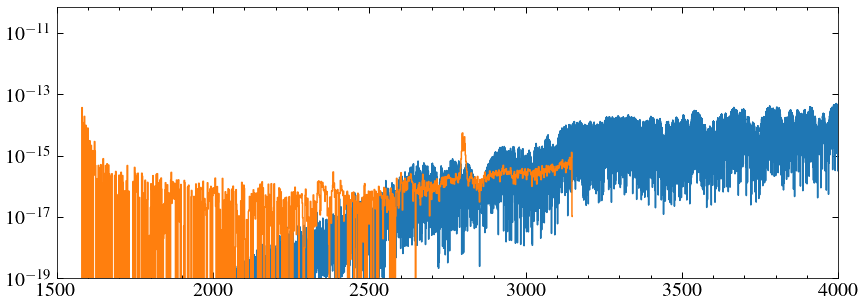

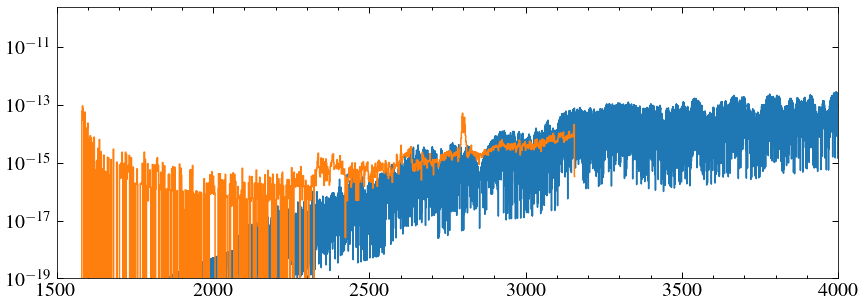

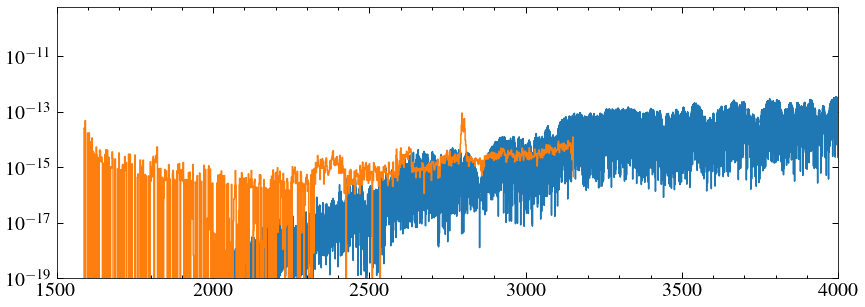

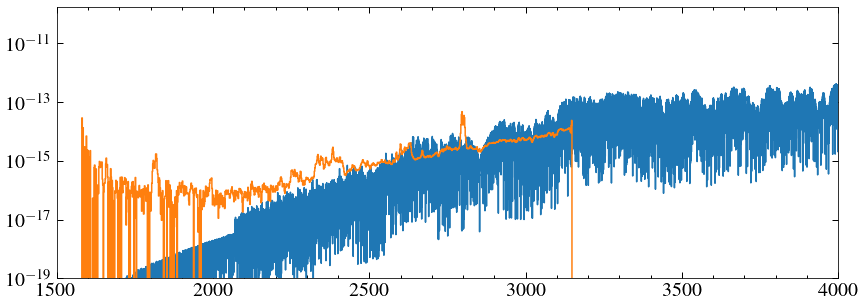

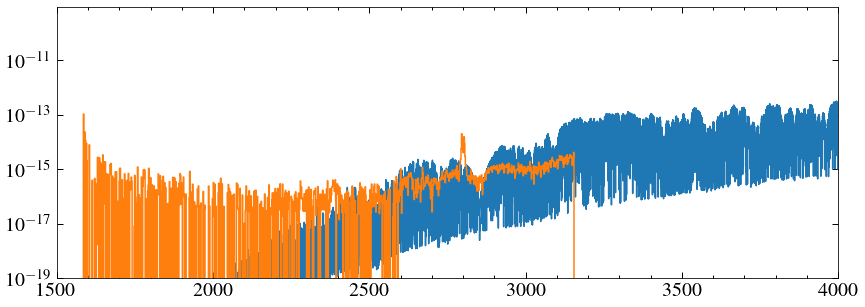

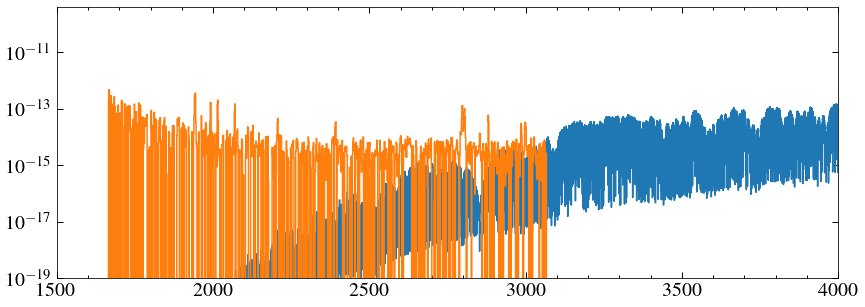

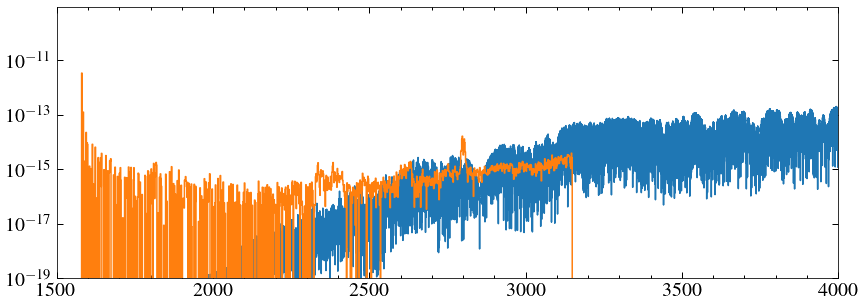

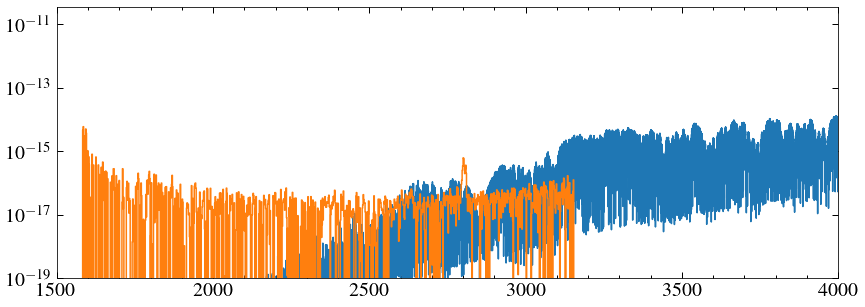

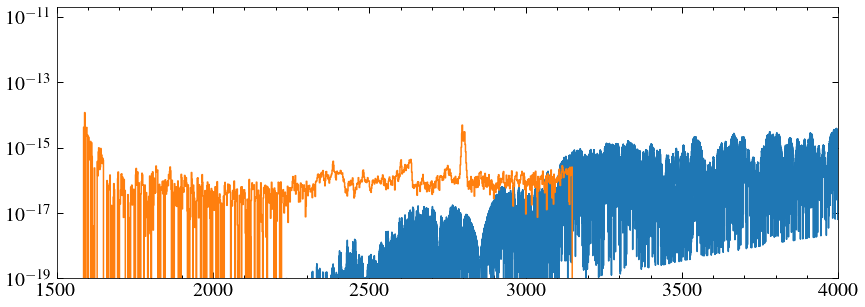

In [4]:
for star in stars:
    # print(star)
    if star != 'TRAPPIST-1':
        ppath = '{}{}/hlsp_muscles_model_phx_{}_na_v10_component-spec.fits'.format(path, star, star.lower())
        phx = fits.getdata(ppath, 1)
        normfac = fits.getheader(ppath, 0)['NORMFAC']
        npath = glob.glob('{}{}/hlsp_muscles_hst_stis_{}_g230l*_v10_component-spec.fits'.format(path, star, star.lower()))[0]
        nuv = fits.getdata(npath, 1)
        plt.plot(phx['WAVELENGTH'], phx['FLUX']*normfac)        
        plt.step(nuv['WAVELENGTH'], nuv['FLUX'], where='mid')
        plt.xlim(1500, 4000)
        plt.yscale('log')
        plt.ylim(1e-19, )
        plt.show()

In [5]:
nuvspecs = glob.glob('{}*/*g230l*.fits'.format(path))
nuvspecs

['/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ1132/hlsp_muscles_hst_stis_gj1132_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ15A/hlsp_muscles_hst_stis_gj15a_g230lb_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ163/hlsp_muscles_hst_stis_gj163_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ649/hlsp_muscles_hst_stis_gj649_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ674/hlsp_muscles_hst_stis_gj674_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_hst_stis_gj676a_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/hlsp_muscles_hst_stis_gj699_g230l_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ729/hlsp_muscles_hst_stis_gj729_g230lb_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/

In [6]:
phxspecs = glob.glob('{}*/*phx*.fits'.format(path))
phxspecs 

['/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ1132/hlsp_muscles_model_phx_gj1132_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ15A/hlsp_muscles_model_phx_gj15a_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ163/hlsp_muscles_model_phx_gj163_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ649/hlsp_muscles_model_phx_gj649_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ674/hlsp_muscles_model_phx_gj674_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_model_phx_gj676a_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/hlsp_muscles_model_phx_gj699_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ729/hlsp_muscles_model_phx_gj729_na_v10_component-spec.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscle

In [7]:
seds = glob.glob('{}*/hlsp_muscles_multi_multi_*_broadband_v10_const-res-sed.fits'.format(path))
seds

['/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ1132/hlsp_muscles_multi_multi_gj1132_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ15A/hlsp_muscles_multi_multi_gj15a_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ163/hlsp_muscles_multi_multi_gj163_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ649/hlsp_muscles_multi_multi_gj649_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ674/hlsp_muscles_multi_multi_gj674_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ676A/hlsp_muscles_multi_multi_gj676a_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ699/hlsp_muscles_multi_multi_gj699_broadband_v10_const-res-sed.fits',
 '/media/david/2tb_ext_hd/hddata/mega_muscles/v10_hlsp/GJ729/hlsp_muscles_multi_multi_gj729_broadband_v10_c

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature         scale        
         K                           
    ----------- ---------------------
         9000.0 2.819831671523709e-13


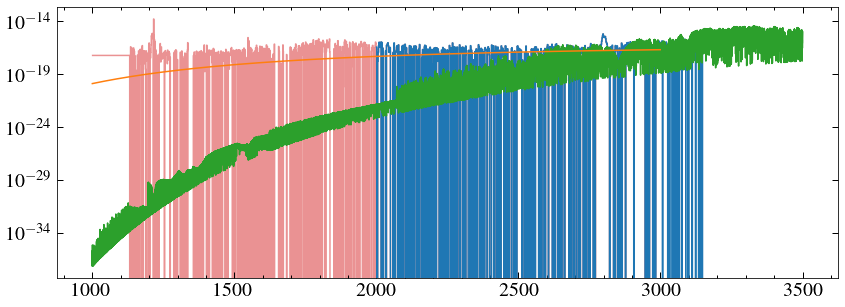

[0. 0. 0. ... 0. 0. 0.] erg / (Angstrom cm2 s sr)


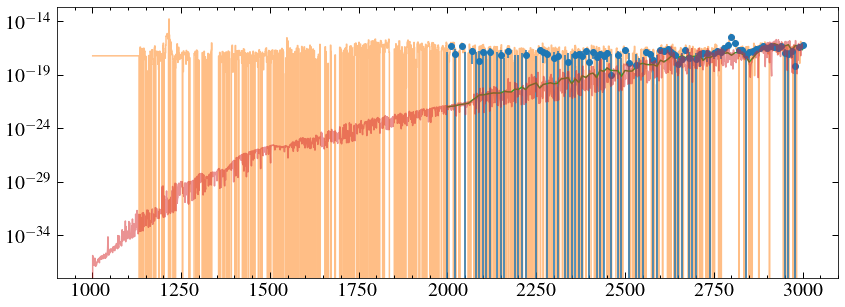

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature         scale        
         K                           
    ----------- ---------------------
         9000.0 8.155183159694818e-10


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


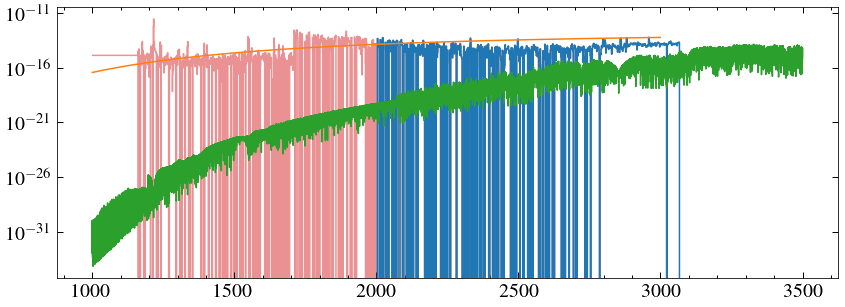

[5.69038399e-17 5.75316806e-17 5.81648846e-17 ... 1.00007150e-14
 1.00019133e-14 1.00031054e-14] erg / (Angstrom cm2 s sr)


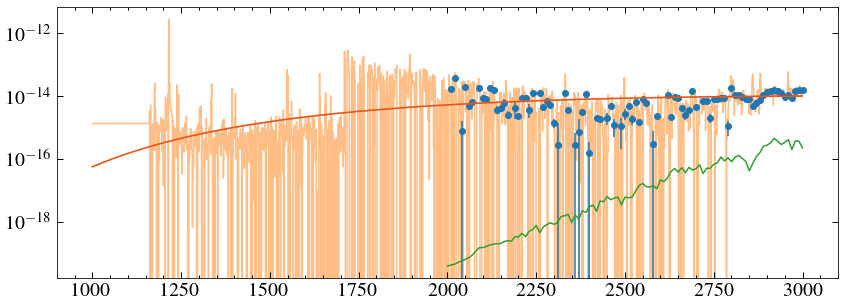

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature         scale        
         K                           
    ----------- ---------------------
         9000.0 2.041893414911081e-12


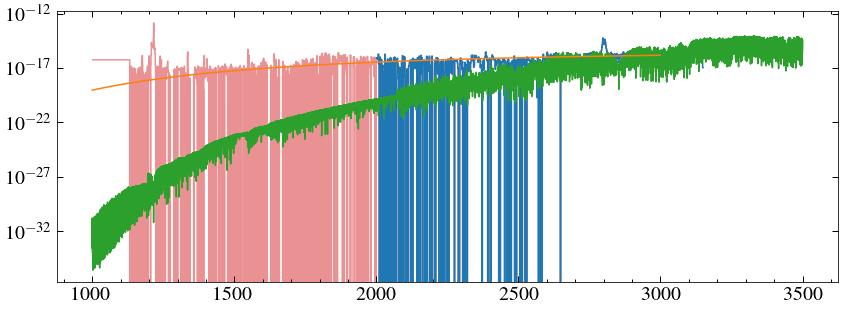

[0. 0. 0. ... 0. 0. 0.] erg / (Angstrom cm2 s sr)


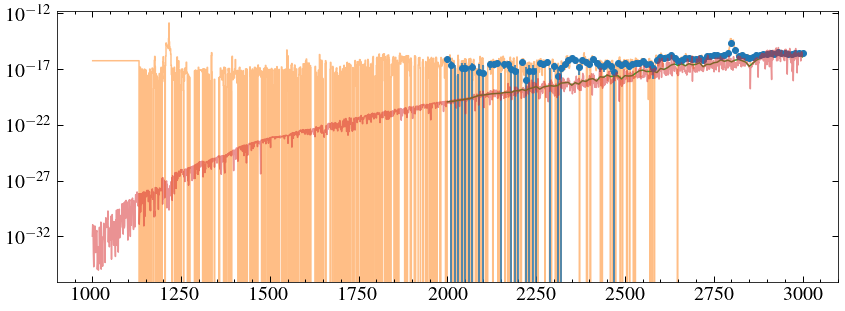

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature        scale        
         K                          
    ----------- --------------------
         9000.0 1.35724154710922e-11


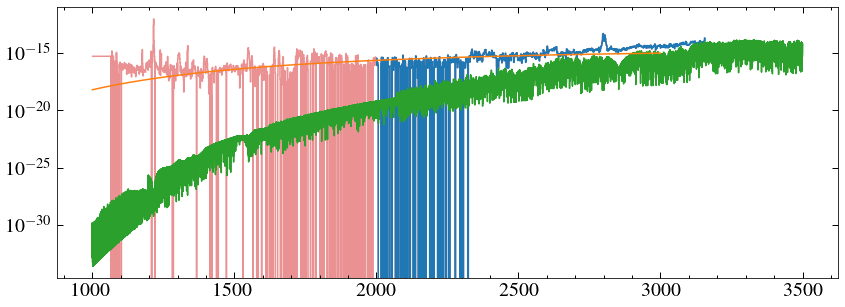

[2.30028811e-18 2.32566803e-18 2.35126475e-18 ... 4.04270186e-16
 4.04318624e-16 4.04366816e-16] erg / (Angstrom cm2 s sr)


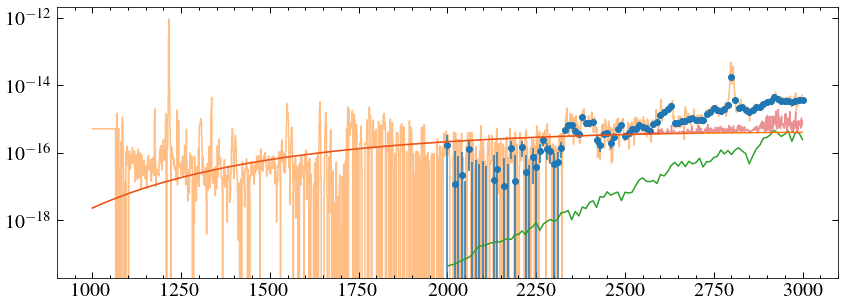

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature         scale         
         K                            
    ----------- ----------------------
         9000.0 1.6783851683658106e-11


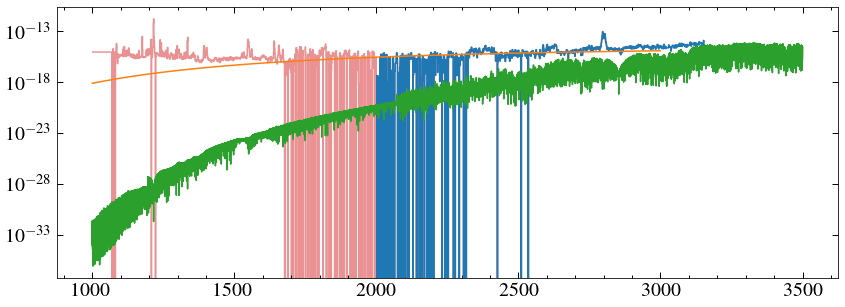

[0. 0. 0. ... 0. 0. 0.] erg / (Angstrom cm2 s sr)


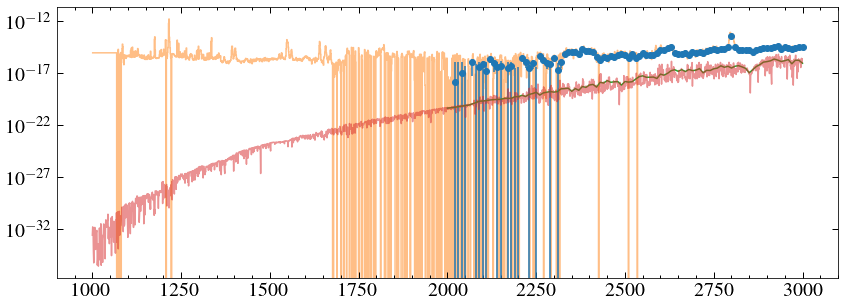

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature         scale        
         K                           
    ----------- ---------------------
         9000.0 6.615241201924556e-10


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


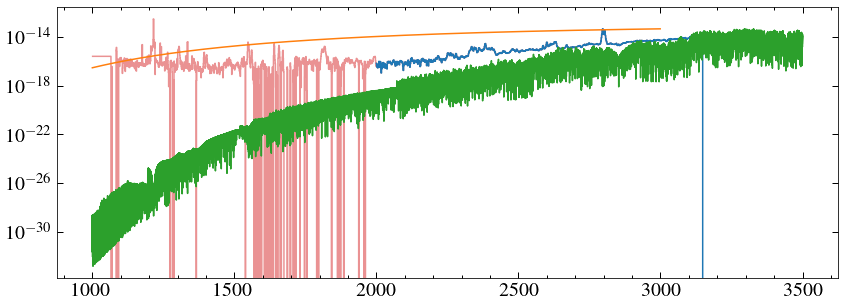

[0. 0. 0. ... 0. 0. 0.] erg / (Angstrom cm2 s sr)


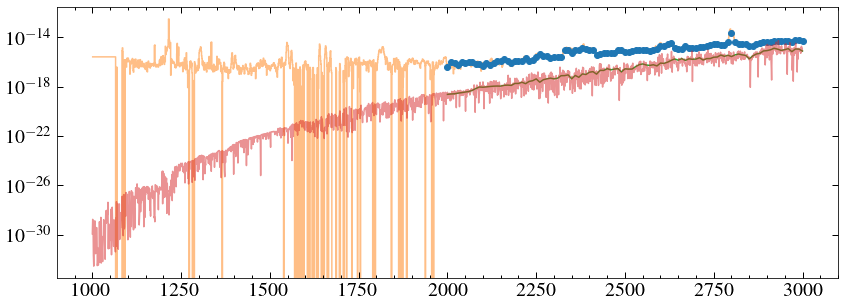

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature         scale         
         K                            
    ----------- ----------------------
         9000.0 1.7690119602537546e-12


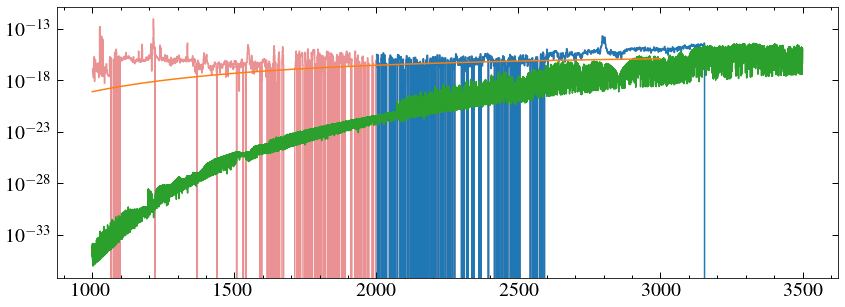

[7.52871732e-19 7.61178439e-19 7.69556106e-19 ... 1.32315423e-16
 1.32331277e-16 1.32347050e-16] erg / (Angstrom cm2 s sr)


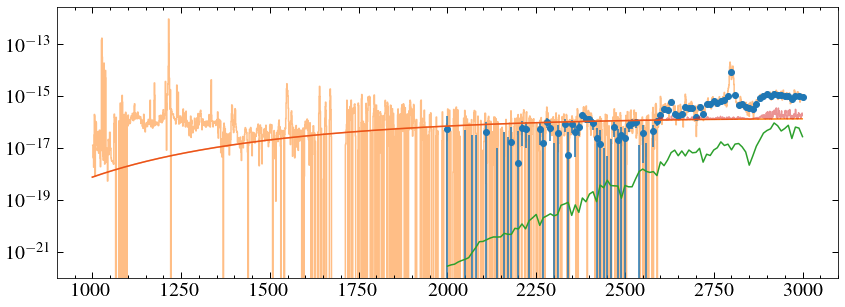

/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature         scale        
         K                           
    ----------- ---------------------
         9000.0 2.838848074740001e-09


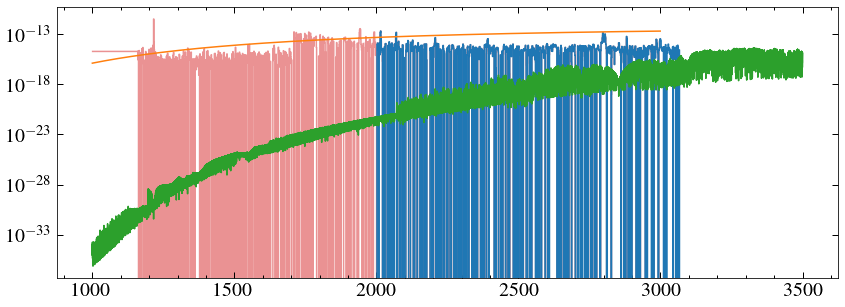

[7.34955417e-19 7.43064447e-19 7.51242747e-19 ... 1.29166673e-16
 1.29182149e-16 1.29197547e-16] erg / (Angstrom cm2 s sr)


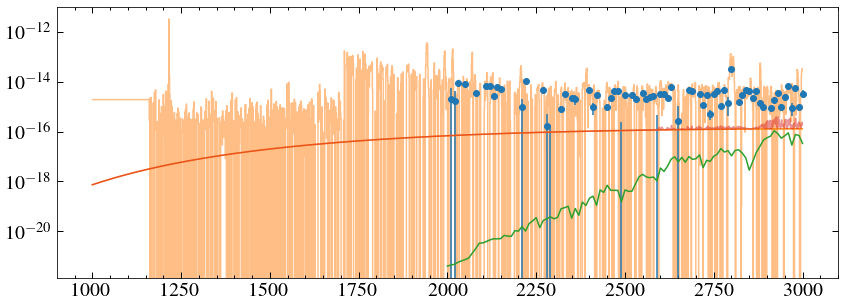

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature         scale        
         K                           
    ----------- ---------------------
         9000.0 1.754031610222435e-12


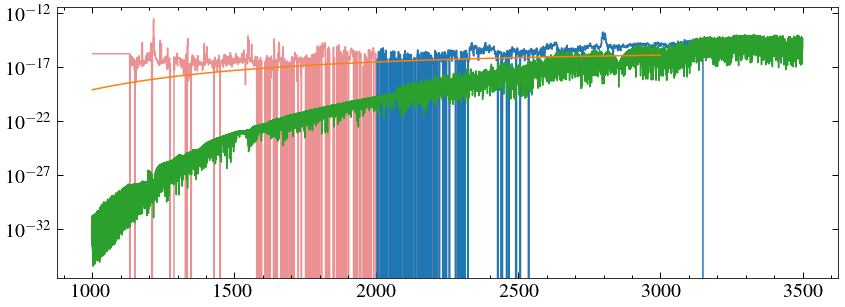

[0. 0. 0. ... 0. 0. 0.] erg / (Angstrom cm2 s sr)


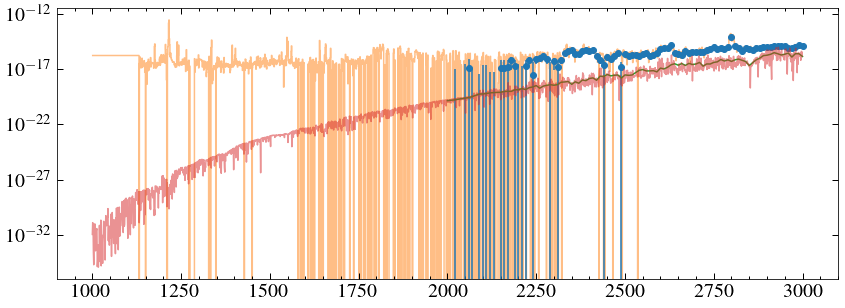

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature        scale        
         K                          
    ----------- --------------------
         9000.0 8.70234088763566e-12


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


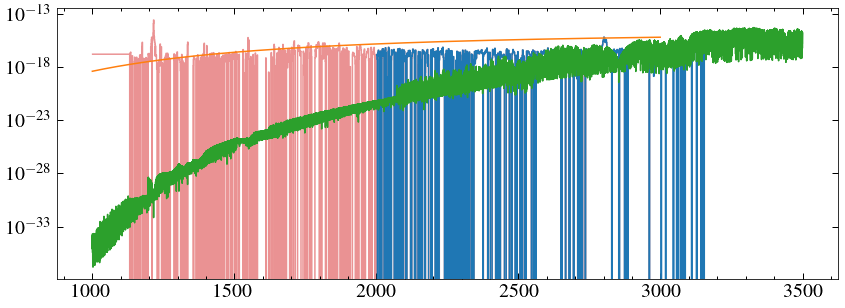

[0. 0. 0. ... 0. 0. 0.] erg / (Angstrom cm2 s sr)


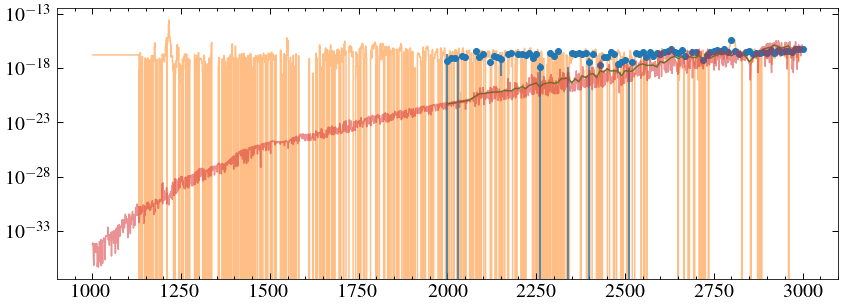

Model: BlackBody
Inputs: ('x',)
Outputs: ('y',)
Model set size: 1
Parameters:
    temperature         scale        
         K                           
    ----------- ---------------------
         9000.0 6.840315294595963e-11


/home/david/anaconda3/envs/astroconda/lib/python3.7/site-packages/ipykernel_launcher.py:17: RuntimeWarning: divide by zero encountered in true_divide


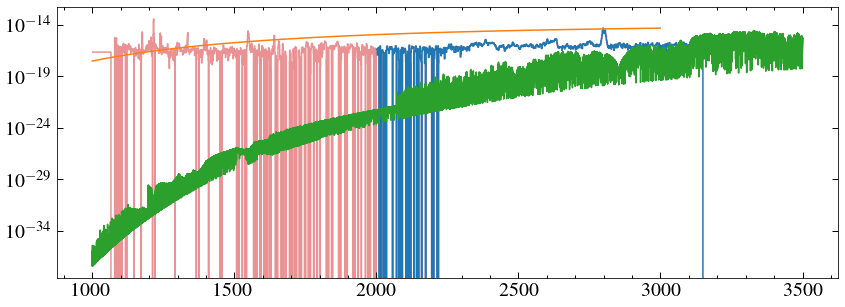

[0. 0. 0. ... 0. 0. 0.] erg / (Angstrom cm2 s sr)


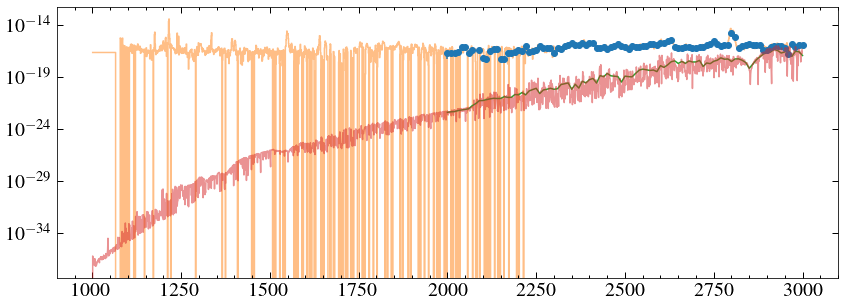

In [21]:
bb = models.BlackBody(temperature=9000*u.K, fixed=dict(temperature=True))#bounds= dict(temperature=[5000*u.k, 13000*u.k])))
wbb = np.arange(1000, 3000, 1)*u.AA
# plt.plot(wbb, bb(wbb))

fitter = fitting.LevMarLSQFitter()

for i, star in enumerate(stars):
    if star != 'TRAPPIST-1':
        nuv = fits.getdata(nuvspecs[i], 1)
        wn, fn, en = nuv['WAVELENGTH'], nuv['FLUX'], nuv['ERROR']
        mask = wn > 2000
        wn, fn, en = wn[mask], fn[mask], en[mask]

        bb = models.BlackBody(temperature=9000*u.K, fixed=dict(temperature=True))
        scale = np.max(bb(wbb))/np.max(fn)
        bb.scale=1/scale.value
        bb_fit = fitter(bb, wn*u.AA, fn, weights = 1/en)

        plt.step(wn, fn, where='mid')
        plt.plot(wbb, bb_fit(wbb), zorder=10)

        phx = fits.getdata(phxspecs[i], 1)
        normfac = fits.getheader(phxspecs[0])['NORMFAC']

        wp, fp = phx['WAVELENGTH'], phx['FLUX']
        mask = (wp > 1000) & (wp < 3500)
        wp, fp = wp[mask], fp[mask]*normfac
        plt.plot(wp, fp)
        plt.yscale('log')

        sed = fits.getdata(seds[i])
        mask = (sed['WAVELENGTH'] > 1000) & (sed['WAVELENGTH'] < 3000)
        plt.step(sed['WAVELENGTH'][mask], sed['FLUX'][mask], where='mid', zorder=-10, alpha=0.5)

        print(bb_fit)

        plt.show()


        binw = np.arange(2000, 3001, 10)
        # wn, fn, en = nuv['WAVELENGTH'], nuv['FLUX'], nuv['ERROR']
        # wn[0]
        wnb, fnb, enb = resample.bintogrid(wn, fn, newx=binw, unc = en) 
        # print(len(wnb))
        
        plt.errorbar(wnb, fnb, enb, ls='none', marker='o')
        wpb, fpb = resample.bintogrid(wp[wp > 2000], fp[wp > 2000], newx=binw)
        # print(len(wpb))
        plt.plot(wpb, fpb, c='C2')
        bb = models.BlackBody(temperature=9000*u.K, fixed=dict(temperature=True))# bounds = dict(temperature=[7000*u.k, 11000*u.k])) )
        scale = np.max(bb(wbb))/np.max(fnb)
        bb.scale=(1/scale.value)*(u.erg/u.s/u.cm**2/u.AA/u.sr)
        bb_fit = fitter(bb, wnb*u.AA, (fnb-fpb)*(u.erg/u.s/u.cm**2/u.AA), weights = 1/(enb*(u.erg/u.s/u.cm**2/u.AA)))

        # plt.step(wn, fn, where='mid')
        plt.plot(wbb, bb_fit(wbb), zorder=10, c='C1')
        pfbb = interpolate.interp1d(wp, fp, fill_value='extrapolate')(wbb)
        print(bb_fit(wbb))
        plt.plot(wbb, bb_fit(wbb).value+pfbb, zorder=12, c='C3', alpha=0.5)

        plt.step(sed['WAVELENGTH'][mask], sed['FLUX'][mask], where='mid', zorder=-10, alpha=0.5)

        plt.yscale('log')
        plt.show()

UnitConversionError: 'erg / (Angstrom cm2 s sr)' and 'erg / (Angstrom cm2 s)' (power density/spectral flux density wav) are not convertible

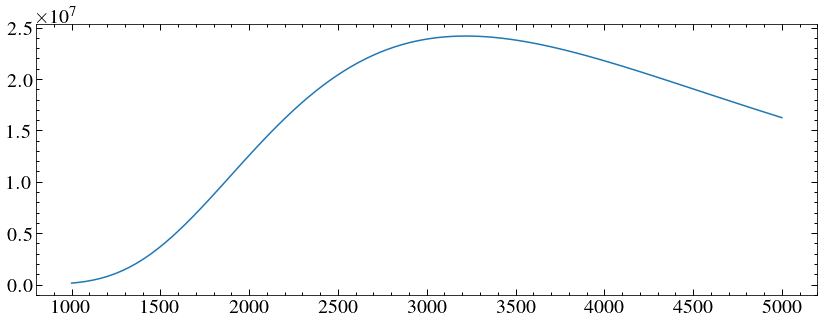

In [30]:
wtest = np.linspace(1000, 5000, 100)*u.AA
bbtest= models.BlackBody(temperature=9000*u.K, scale=1*(u.erg/u.s/u.cm**2/u.AA/u.sr))
plt.plot(wtest, bbtest(wtest))
plt.plot(wtest, bbtest(wtest).to((u.erg/u.s/u.cm**2/u.AA)))